In [133]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn.model_selection as sms
import seaborn as sns
import statsmodels.api as sm

本文包括两个ridge L2 regression model，两个模型的因变量分别为：zDEF、zEMOF。
主要难点在于报告p值与mse，因为机器学习不太关注p值，因此调用了statsmodels包来解决该问题。
此外，本文使用了seaborn包绘制预测图。

首先，通过kfold函数准备cross validation
然后，使用sklearn包中的linear_model建立回归模型，并返回了p值,r值与mse值----这一切封装在get_rs函数中。
此外，main函数将结果转化为更容易观看的dataframe格式
最后，进行了绘图，并保存图片。

此文的目的在于提供一个参考模板，以便不熟悉sklearn模块的同学使用。因此，其中的参数与函数是非常方便大家自定义的。
注意，本文并没有解决permutation test如何运行的问题。

In [4]:
df = pd.read_csv('df.csv')
df

,NewID,Age,Sex,DecF,EmoF,GMV,OFG,mPFC,IPL,BA10,zOFG,zmPFC,zIPL,zBA10,zDEF,zEMOF,fold
0,18001,20,1,18,17,0.4318,0.5992,0.3953,0.4403,0.3911,1.294454,-0.578756,1.639499,0.023261,-0.866247,-0.851700,3
1,18002,20,1,23,21,0.4059,0.4636,0.3234,0.4361,0.3153,-1.210914,-2.028123,2.213551,-1.365179,0.381225,0.255666,2
2,18003,21,1,24,22,0.3971,0.5603,0.3641,0.3220,0.3115,1.847327,-0.251324,-0.497498,-1.201391,0.637326,0.561031,3
3,18004,20,1,28,25,0.3798,0.4875,0.3528,0.2717,0.3315,0.720302,0.155308,-1.397628,0.151318,1.627798,1.362274,2
4,18005,21,2,20,21,0.3798,0.4731,0.3632,0.3127,0.3347,0.016359,0.227684,-0.673578,0.082686,-0.217518,0.450055,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,18b34,22,1,25,20,0.4416,0.5699,0.4589,0.3463,0.4370,-0.101058,1.150053,-0.995720,0.979178,1.132858,0.164231,3
298,18b35,20,2,25,21,0.3818,0.4515,0.3278,0.3391,0.3018,-0.627179,-1.064676,-0.077025,-0.974656,1.132414,0.420300,2
299,18b36,22,2,24,24,0.3554,0.4055,0.3235,0.3191,0.3057,-0.727678,-0.195557,0.179347,0.054372,0.786797,1.299062,2
300,18b37,20,1,21,18,0.3848,0.5469,0.3859,0.3126,0.3287,2.126040,1.122716,-0.459796,-0.129643,-0.259086,-0.728414,3


In [144]:
def kfold(group='fold',X=['zOFG'],y='zDEF'):
    for i in pd.unique(df[group]):
        X_train = df.loc[df[group]!=i,X]
        y_train = df.loc[df[group]!=i,[y]]
        X_test = df.loc[df[group]==i,X]
        y_test = df.loc[df[group]==i,[y]]
        yield (X_train,y_train,X_test,y_test,i)

In [145]:
def get_rs(X_train,y_train,X_test,y_test): 
    reg = linear_model.Ridge(alpha=.5)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # rMSE r p
    rMSE = metrics.mean_squared_error(y_test, y_pred)

    # formula = 'y ~ x1 + x2 + x3'
    from scipy.stats import zscore as zsc
    rOLS = sm.OLS(zsc(y_test),zsc(y_pred))
    rs = rOLS.fit()
    r = rs.params
    p = rs.pvalues
    return rMSE,r[0],p[0],y_pred,y_test

zOFG对zDEF的预测

In [163]:
def main(dfs,group='fold',X=['zOFG'],y='zDEF'):
    rs = {}
    pyy = pd.DataFrame(columns=['y_pred','y_test','fold'])
    for i,j,k,l,m in kfold(group,X,y):
        rMSE,r,p,y_pred,y_test= get_rs(i,j,k,l)
        rs.setdefault("MSE", []).append(rMSE)
        rs.setdefault("r", []).append(r)
        rs.setdefault("p", []).append(p)
        temp = pd.DataFrame({'y_pred':y_pred[:,0],'y_test':y_test.values[:,0]})
        temp['fold'] = m
        pyy = pyy.append(temp)
    return pd.DataFrame(rs),pyy

In [164]:
rs,pyy = main(dfs)

In [165]:
rs

,MSE,r,p
0,0.887945,0.244338,0.013799
1,0.947144,0.260722,0.008129
2,0.922118,0.309244,0.001564


In [166]:
np.mean(rs,axis=0)

MSE    0.919069
r      0.271435
p      0.007831
dtype: float64

Text(10.631406250000005, 0.5, 'actual zOFG')

<Figure size 360x864 with 0 Axes>

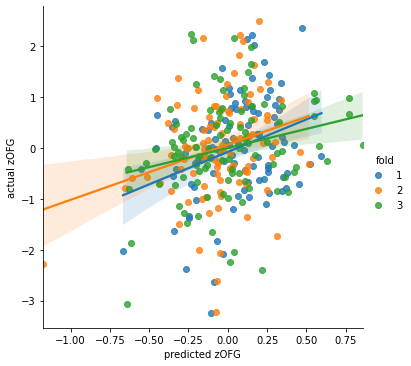

In [160]:
plt.figure(figsize=(5,12))
#sns.regplot(data=df2,x='y', y='predicted', ci=95)
sns.lmplot(x="y_pred",y="y_test",hue="fold",data=pyy)
plt.xlabel("predicted zOFG")
plt.ylabel("actual zOFG")
plt.savefig(u'Prediction performance.pdf')

zmPFC、zIPL、zBA10对zEMOF的预测

In [167]:
rs1,pyy1 = main(dfs,'fold',['zmPFC','zIPL','zBA10'],'zDEF')

In [168]:
rs1

,MSE,r,p
0,0.971300,0.072992,0.468207
1,1.013953,0.124992,0.210676
2,0.932527,0.372168,0.000117


In [169]:
np.mean(rs1,axis=0)

MSE    0.972593
r      0.190051
p      0.226333
dtype: float64

Text(10.631406250000005, 0.5, 'actual zEMOF')

<Figure size 360x864 with 0 Axes>

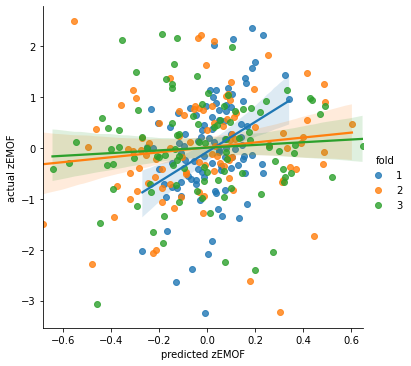

In [172]:
plt.figure(figsize=(5,12))
sns.lmplot(x="y_pred",y="y_test",hue="fold",data=pyy1)
plt.xlabel("predicted zEMOF")
plt.ylabel("actual zEMOF")
plt.savefig(u'Prediction performance2.pdf')